In [1]:
import pandas as pd
import numpy as np
import os

from torch.nn.functional import linear

from notebook_tests.ViTExplination import label

In [2]:
def unnormalize_sxr(normalized_values, sxr_norm):
    return 10 ** (normalized_values * float(sxr_norm[1].item()) + float(sxr_norm[0].item())) - 1e-8
def normalize_sxr(unnormalized_values, sxr_norm):
    """Convert from unnormalized to normalized space"""
    log_values = np.log10(unnormalized_values + 1e-8)
    normalized = (log_values - float(sxr_norm[0].item())) / float(sxr_norm[1].item())
    return normalized

In [3]:
def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        # Try to find Barlow font with more specific search
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)

        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            # Try alternative approach - directly specify font file
            barlow_path = '/usr/share/fonts/truetype/barlow/Barlow-Regular.ttf'
            barlow_path2 = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                # Add the font file directly to matplotlib
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            elif os.path.exists(barlow_path2):
                fm.fontManager.addfont(barlow_path2)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path2}")
            else:
                # Fallback to sans-serif
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")
setup_barlow_font()

Font setup error: name 'fm' is not defined, using default font


In [4]:
train = pd.read_csv("/Volumes/T9/FOXES_Data/train_data_combined.csv")
val = pd.read_csv("/Volumes/T9/FOXES_Data/val_data_combined.csv")
test = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")
test = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")
sxr_norms = np.load('/Volumes/T9/FOXES_Data/SXR/normalized_sxr.npy')


--- Validation Results ---
Best Alpha: None
Mean Squared Error (log scale) on Val: 0.0992133682074839
R-squared (log scale) on Val: 0.23965163604406303

--- Per-Class Performance (Validation) ---
  Class B: MSE=0.1333, MAE=0.3469, R²=-20.9595, n=257
  Class C: MSE=0.0684, MAE=0.2339, R²=-0.3225, n=14553
  Class M: MSE=0.3772, MAE=0.5725, R²=-6.5288, n=1487
  Class X: MSE=1.4248, MAE=0.9567, R²=-143.0710, n=20

EVALUATING ON TEST SET

--- Overall Test Results ---
Mean Squared Error (log scale): 0.141106
Root Mean Squared Error (log scale): 0.375641
Mean Absolute Error (log scale): 0.306695
R-squared (log scale): 0.492514

--- Per-Class Performance (Test) ---
  Class B: MSE=0.2248, MAE=0.4680, R²=-37.3694, n=13600
  Class C: MSE=0.0876, MAE=0.2497, R²=0.0158, n=63038
  Class M: MSE=0.1903, MAE=0.3493, R²=-2.1093, n=22368
  Class X: MSE=1.1873, MAE=0.7176, R²=-27.9488, n=1086

--- Validation vs Test Comparison ---
Metric                    Validation      Test            Difference     


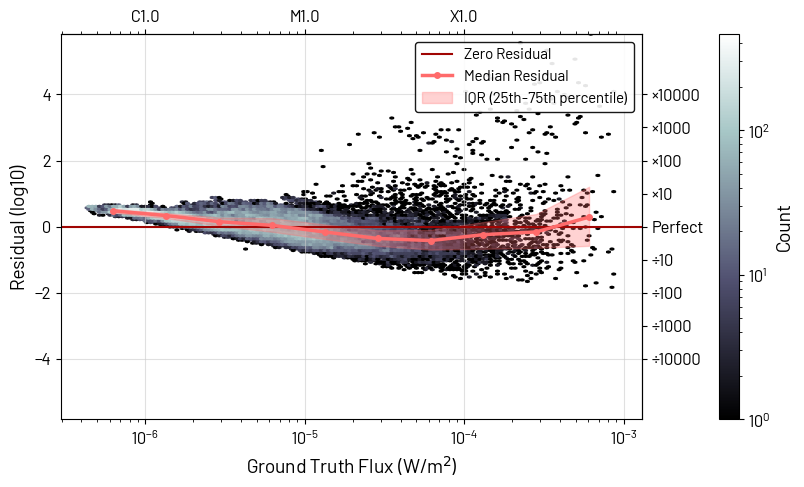

In [86]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Prepare features (X) and target (y)
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]
X_train = train[feature_cols]
y_train = train['sxr_flux_normalized']

X_val = val[feature_cols]
y_val = val['sxr_flux_normalized']

# Define flare class boundaries (in unnormalized W/m^2)
def get_flare_class(sxr_flux):
    """
    Assign flare class based on SXR flux
    Returns: 'A', 'B', 'C', 'M', or 'X'
    """
    flux = np.abs(sxr_flux)
    # if flux < 1e-7:
    #     return 'A'
    if flux < 1e-6:
        return 'B'
    elif flux < 1e-5:
        return 'C'
    elif flux < 1e-4:
        return 'M'
    else:
        return 'X'

linear = LinearRegression()
linear.fit(X_train, y_train, sample_weight=train_weights)

# Evaluation on Validation set with best model
y_pred_val = linear.predict(X_val)

# Un-normalize data for analysis
y_val_unnorm = np.maximum(val['sxr_flux'], 1e-8)
y_pred_val_unnorm = np.maximum(unnormalize_sxr(y_pred_val, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_val_log = np.log10(y_val_unnorm)
y_pred_val_log = np.log10(y_pred_val_unnorm)

mse_log = mean_squared_error(y_val_log, y_pred_val_log)
r2_log = r2_score(y_val_log, y_pred_val_log)

print(f"\n--- Validation Results ---")
print(f"Best Alpha: {best_alpha}")
print(f"Mean Squared Error (log scale) on Val: {mse_log}")
print(f"R-squared (log scale) on Val: {r2_log}")


# Calculate per-class performance on validation set
print("\n--- Per-Class Performance (Validation) ---")
val_classes = np.array([get_flare_class(f) for f in val['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = val_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_val_log[mask], y_pred_val_log[mask])
        cls_mae = mean_absolute_error(y_val_log[mask], y_pred_val_log[mask])
        cls_r2 = r2_score(y_val_log[mask], y_pred_val_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# ===== TEST SET EVALUATION =====
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Prepare test data
X_test = test[feature_cols]
y_test = test['sxr_flux_normalized']

# Make predictions on test set
y_pred_test = linear.predict(X_test)

# Un-normalize data for analysis
y_test_unnorm = np.maximum(test['sxr_flux'], 1e-8)
y_pred_test_unnorm = np.maximum(unnormalize_sxr(y_pred_test, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_test_log = np.log10(y_test_unnorm)
y_pred_test_log = np.log10(y_pred_test_unnorm)

mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test_log, y_pred_test_log)
r2_test_log = r2_score(y_test_log, y_pred_test_log)

print(f"\n--- Overall Test Results ---")
print(f"Mean Squared Error (log scale): {mse_test_log:.6f}")
print(f"Root Mean Squared Error (log scale): {rmse_test_log:.6f}")
print(f"Mean Absolute Error (log scale): {mae_test_log:.6f}")
print(f"R-squared (log scale): {r2_test_log:.6f}")

# Calculate per-class performance on test set
print("\n--- Per-Class Performance (Test) ---")
test_classes = np.array([get_flare_class(f) for f in test['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = test_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_test_log[mask], y_pred_test_log[mask])
        cls_mae = mean_absolute_error(y_test_log[mask], y_pred_test_log[mask])
        cls_r2 = r2_score(y_test_log[mask], y_pred_test_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# Compare validation vs test performance
print("\n--- Validation vs Test Comparison ---")
print(f"{'Metric':<25} {'Validation':<15} {'Test':<15} {'Difference':<15}")
print("-" * 70)
print(f"{'MSE (log scale)':<25} {mse_log:<15.6f} {mse_test_log:<15.6f} {mse_test_log - mse_log:<15.6f}")
print(f"{'R² (log scale)':<25} {r2_log:<15.6f} {r2_test_log:<15.6f} {r2_test_log - r2_log:<15.6f}")

# ===== VISUALIZATION =====
print("\n" + "="*60)
print("GENERATING PLOTS")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.font_manager as fm
from matplotlib import rcParams

def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        # Try to find Barlow font with more specific search
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)

        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            # Try alternative approach - directly specify font file
            barlow_path = '/usr/share/fonts/truetype/barlow/Barlow-Regular.ttf'
            barlow_path2 = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                # Add the font file directly to matplotlib
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            elif os.path.exists(barlow_path2):
                fm.fontManager.addfont(barlow_path2)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path2}")
            else:
                # Fallback to sans-serif
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")

def plot_regression_with_residuals(y_true, y_pred, title=""):
    """
    Generate regression comparison plot with residuals subplot.

    Creates a comprehensive visualization showing:
    - Top panel: 2D histogram of predicted vs. actual values with MAE contours
    - Bottom panel: Residuals (predicted - actual) in log space showing systematic bias
    - Perfect prediction line (1:1 relationship)
    - Flare class boundaries (A, B, C, M, X)
    - Logarithmic scaling for both axes
    - Professional styling with Barlow font and custom color scheme
    """
    setup_barlow_font()

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    theme = 'white'
    axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
    text_color = 'black' if theme == 'white' else '#FFFFFF'
    legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
    grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
    minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
    legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
    colorbar_facecolor = axis_facecolor
    figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

    def add_flare_class_axes(ax, min_val, max_val, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_top = ax.secondary_xaxis('top', functions=(identity, identity))

        # Collect tick positions + labels
        flare_positions = []
        flare_labels = []

        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= max_val:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)

        # Apply ticks
        ax_top.set_xticks(flare_positions)
        ax_top.set_xticklabels(
            flare_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )

        # Styling
        # ax_top.tick_params(colors=tick_color, length=6, width=1)
        # ax_right.tick_params(colors=tick_color, length=6, width=1)

        # Remove grids + backgrounds (important)
        ax_top.grid(False)



    def add_residual_class_axes(ax, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_right = ax.secondary_yaxis('right', functions=(identity, identity))

        # Collect tick positions + labels
        residual_positions = [-4,-3,-2,-1,0,1,2,3,4]
        residual_labels = ["÷10000","÷1000","÷100","÷10","Perfect","×10","×100","×1000","×10000"]


        # Apply ticks
        ax_right.set_yticks(residual_positions)
        ax_right.set_yticklabels(
            residual_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )


    # Create figure with 2 subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')

    fig.patch.set_facecolor(figure_facecolor)
    fig.patch.set_alpha(1.0)



    # ===== BOTTOM PANEL: RESIDUALS =====
    # Calculate residuals in log space
    residuals = np.log10(y_pred) - np.log10(y_true)
    # Create 2D histogram for residuals
    h1 = ax1.hexbin(y_true, residuals, gridsize=150,
                    cmap="bone", alpha=1, xscale="log", bins="log")

    # Add zero line (perfect prediction)
    ax1.axhline(y=0, color='#A00503', linestyle='-', linewidth=1.5, label='Zero Residual', zorder=10)

    # Calculate and plot binned median residuals to show systematic bias
    min_val = min(y_true)
    max_val = max(y_true)
    n_bins = 10
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), n_bins + 1)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # Geometric mean
    median_residuals = []
    q25_residuals = []
    q75_residuals = []

    for i in range(n_bins):
        mask = (y_true >= bin_edges[i]) & (y_true < bin_edges[i+1])
        if np.sum(mask) > 5:  # Only compute if enough samples
            median_residuals.append(np.median(residuals[mask]))
            q25_residuals.append(np.percentile(residuals[mask], 25))
            q75_residuals.append(np.percentile(residuals[mask], 75))
        else:
            median_residuals.append(np.nan)
            q25_residuals.append(np.nan)
            q75_residuals.append(np.nan)

    ax1.plot(bin_centers, median_residuals, color='#FF6B6B', linewidth=2.5,
             label='Median Residual', zorder=11, marker='o', markersize=4)
    ax1.fill_between(bin_centers, q25_residuals, q75_residuals,
                     color='#FF6B6B', alpha=0.3, label='IQR (25th-75th percentile)', zorder=9)

    # Styling
    ax1.set_facecolor(axis_facecolor)
    ax1.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    #ax2.set_xscale('log')
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)

    # Grid styling
    # ax2.grid(True, which='minor', alpha=0.15, linewidth=0.25, linestyle='--', color=minor_grid_color)
    # ax2.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    # ax2.tick_params(which='minor', colors=text_color)

    # Legend
    legend2 = ax1.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    # Set tick labels to Barlow font
    for label in ax1.get_xticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)
    for label in ax1.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    # # Colorbar styling
    cbar = fig.colorbar(h1, ax=[ax1], orientation='vertical', pad=.1)
    cbar.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')
    cbar.ax.tick_params(colors=text_color)
    cbar.ax.yaxis.set_tick_params(colors=text_color)
    cbar.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar.ax.tick_params(which='minor', colors=text_color)
    cbar.ax.set_facecolor(colorbar_facecolor)
    cbar.ax.patch.set_alpha(1.0)

    # Set colorbar tick labels to Barlow font
    for label in cbar.ax.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    # Set spines
    for spine in ax1.spines.values():
        spine.set_color(text_color)
        spine.set_zorder(10)


    add_flare_class_axes(ax1, min_val, max_val, text_color)
    add_residual_class_axes(ax1,text_color)
    m = max(max(residuals),np.abs(min(residuals)))
    plt.ylim([-m,m])
    #plt.close()
    return fig, residuals


# # Plot validation results
# print("\nGenerating validation set plot...")
# plot_regression_with_residuals(y_val_unnorm, y_pred_val_unnorm)

# Plot test results
print("Generating test set plot...")
_, residuals = plot_regression_with_residuals(y_test_unnorm, y_pred_test_unnorm)

In [6]:
res = pd.read_csv("/Volumes/T9/FOXES_Data/paper_res/vit/vit_predictions_removed_outliers.csv")

In [7]:
res

,timestamp,predictions,groundtruth
0,2023-08-01T00:00:00,0.000003,0.000003
1,2023-08-01T00:01:00,0.000003,0.000003
2,2023-08-01T00:03:00,0.000003,0.000003
3,2023-08-01T00:04:00,0.000003,0.000003
4,2023-08-01T00:05:00,0.000003,0.000003
...,...,...,...
100087,2025-09-26T20:17:00,0.000004,0.000004
100088,2025-09-26T20:18:00,0.000004,0.000004
100089,2025-09-26T20:19:00,0.000003,0.000004
100090,2025-09-26T20:20:00,0.000003,0.000003


Using Barlow font: Barlow


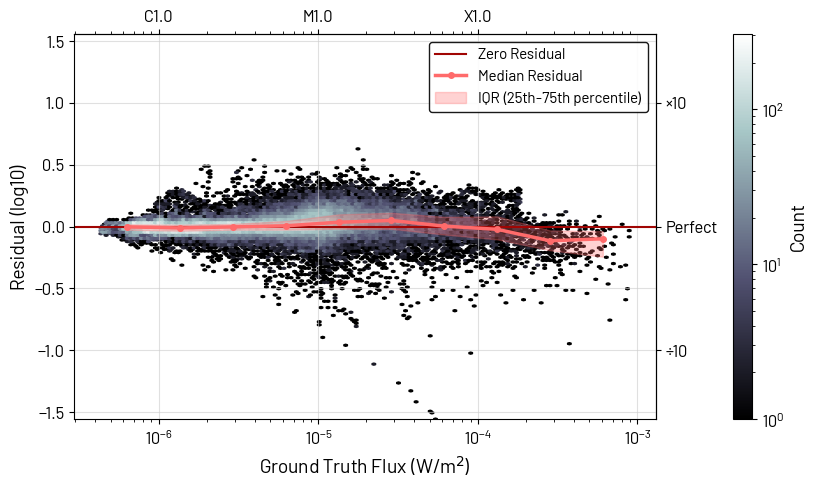

In [19]:
_, resid = plot_regression_with_residuals(res['groundtruth'],res['predictions'])

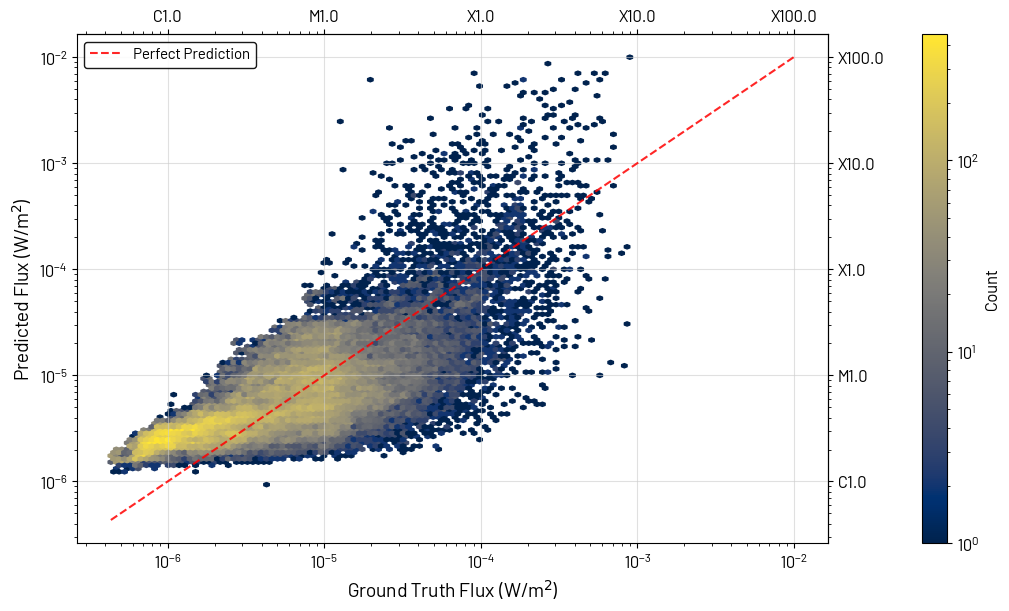

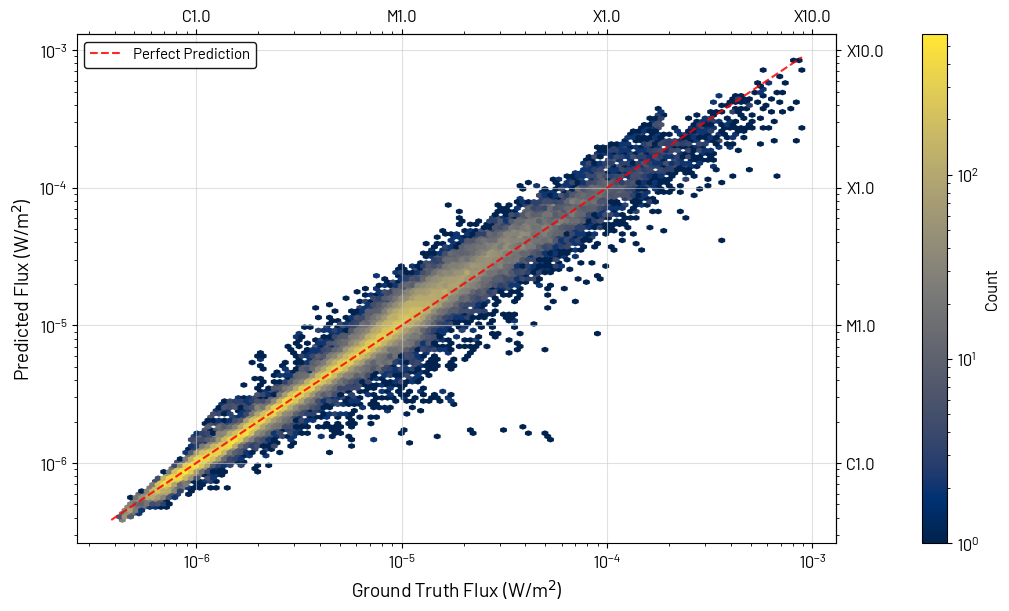

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams

theme = 'white'
axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
text_color = 'black' if theme == 'white' else '#FFFFFF'
legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
colorbar_facecolor = axis_facecolor
figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'
def plot_solar_regression_hexbins(y_true, y_pred):
    # --- 1. Setup & Styling ---
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Barlow', 'Arial', 'DejaVu Sans']

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }
    # Solar Flare Definitions
    def add_flare_class_axes(ax, min_val, max_val, tick_color):
            """
            Add flare class labels using true secondary axes that are
            mathematically tied to the parent axis.
            """

            # Identity transform (log space already handled by parent)
            def identity(x):
                return x

            # Create secondary axes
            ax_top = ax.secondary_xaxis('top', functions=(identity, identity))
            ax_right = ax.secondary_yaxis('right', functions=(identity, identity))
            # Collect tick positions + labels
            flare_positions = []
            flare_labels = []

            for class_name, (min_flux, max_flux) in flare_classes.items():
                if min_val <= min_flux <= 9999:
                    flare_positions.append(min_flux)
                    flare_labels.append(class_name)

            # Apply ticks
            ax_top.set_xticks(flare_positions)
            ax_top.set_xticklabels(
                flare_labels,
                fontsize=12,
                color=tick_color,
                fontfamily='Barlow'
            )

            # Remove grids + backgrounds (important)
            ax_top.grid(False)

            ax_right.set_yticks(flare_positions)
            ax_right.set_yticklabels(
                flare_labels,
                fontsize=12,
                color=tick_color,
                fontfamily='Barlow'
            )

            # Remove grids + backgrounds (important)
            ax_right.grid(False)

    # Data Prep
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = (y_true > 0) & (y_pred > 0)
    y_true, y_pred = y_true[mask], y_pred[mask]


    # Limits
    vmin, vmax = 1e-9, 1e-2  # Fixed limits for standard solar range, or use min/max
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    


    # --- 2. Figure Setup ---
    # Using constrained_layout to support secondary axes and colorbars
    fig = plt.figure(figsize=(10, 6), layout='constrained')
    gs = fig.add_gridspec(1, 1)

    ax_main = fig.add_subplot(gs[0])

    # --- 3. TOP PANEL: Prediction (Hexbin) ---
    # 'inferno' or 'magma' works well for "Heat/Solar" data
    hb1 = ax_main.hexbin(y_true, y_pred, gridsize=125, xscale='log', yscale='log',
                         cmap='cividis', mincnt=1, bins='log',
                         extent=(np.log10(vmin), np.log10(vmax), np.log10(vmin), np.log10(vmax)))
    
    # hb2 = ax_main.hexbin(new_y_true, new_y_pred, gridsize=100, xscale='log', yscale='log',
    #                      cmap='inferno', mincnt=1, bins='log',
    #                      extent=(np.log10(vmin), np.log10(vmax), np.log10(vmin), np.log10(vmax)))

    # 1:1 Line
    ax_main.plot([vmin, vmax], [vmin, vmax], ls='--', c='red', alpha=0.85, lw=1.5, label="Perfect Prediction")

    # Decoration
    #ax_main.set_xlim(vmin, vmax)
    #ax_main.set_ylim(vmin, vmax)
    ax_main.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14)
    ax_main.set_ylabel(r'Predicted Flux (W/m$^{2}$)', fontsize=14)
    ax_main.tick_params(labelsize=12, colors=text_color)
    ax_main.grid(True, alpha=0.6, color=grid_color)

    legend2 = ax_main.legend(loc='upper left', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    # Set tick labels to Barlow font
    for label in ax_main.get_xticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)
    for label in ax_main.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)


    # --- 5. Colorbars ---
    cbar = fig.colorbar(hb1, ax=[ax_main], orientation='vertical')
    cbar.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar.set_label("Count", fontsize=12, color=text_color, fontfamily='Barlow')
    cbar.ax.tick_params(colors=text_color)
    cbar.ax.yaxis.set_tick_params(colors=text_color)
    cbar.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar.ax.tick_params(which='minor', colors=text_color)
    cbar.ax.set_facecolor(colorbar_facecolor)
    cbar.ax.patch.set_alpha(1.0)
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    add_flare_class_axes(ax_main, vmin, vmax, text_color)
    return fig


# Dummy data for testing

fig = plot_solar_regression_hexbins(y_test_unnorm, y_pred_test_unnorm)
plt.savefig("linear_base.png",dpi=400)
plt.show()

fig = plot_solar_regression_hexbins(res['groundtruth'],res['predictions'] )
#plt.savefig("vit_pred.png",dpi=400)
plt.show()



Using Barlow font: Barlow


(<Figure size 1000x1000 with 4 Axes>,
 0         0.091058
 1         0.172975
 2         0.178250
 3         0.187223
 4         0.185112
             ...   
 100087    0.116419
 100088    0.135797
 100089    0.154443
 100090    0.172657
 100091    0.172374
 Name: sxr_flux, Length: 100092, dtype: float64)

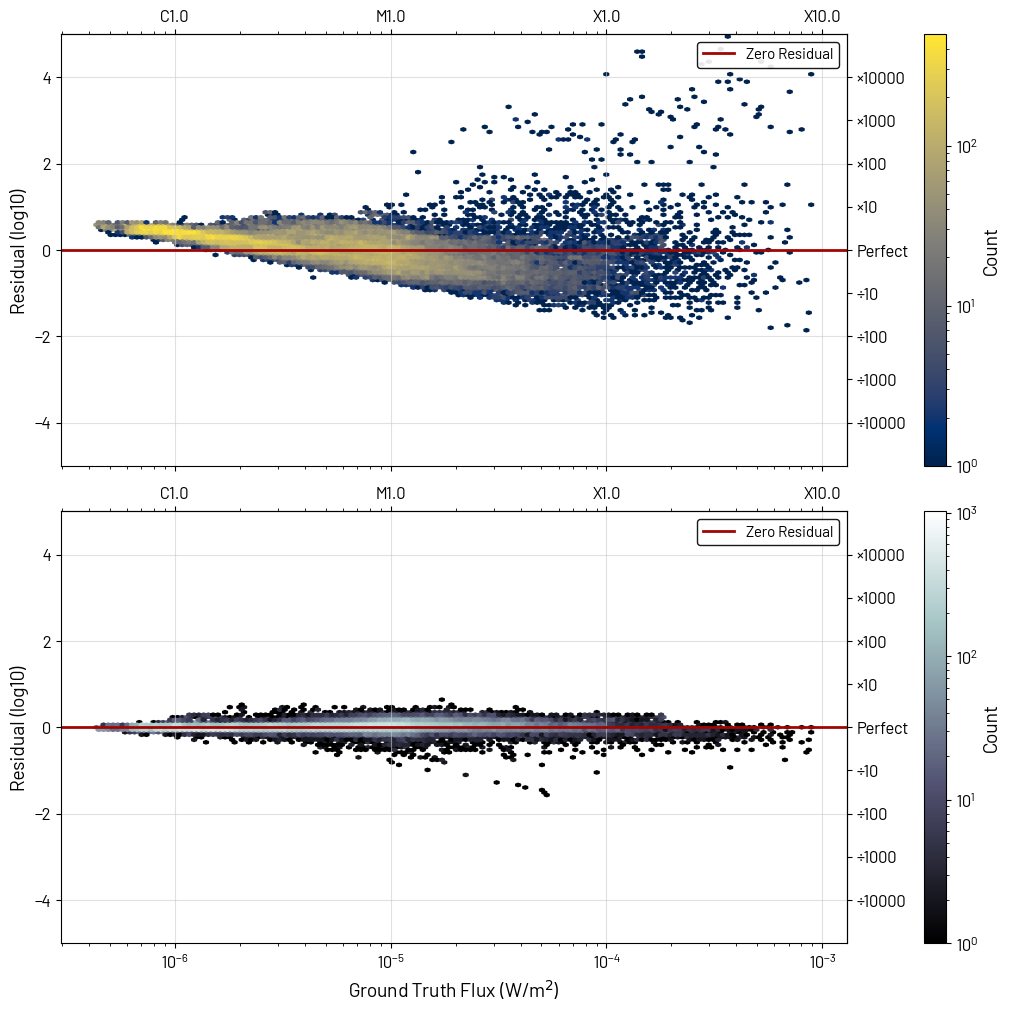

In [165]:
def residual_comparison(y_true, y_pred, new_y_true, new_y_pred):
    setup_barlow_font()

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    theme = 'white'
    axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
    text_color = 'black' if theme == 'white' else '#FFFFFF'
    legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
    grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
    minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
    legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
    colorbar_facecolor = axis_facecolor
    figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

    def add_flare_class_axes(ax, min_val, max_val, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_top = ax.secondary_xaxis('top', functions=(identity, identity))

        # Collect tick positions + labels
        flare_positions = []
        flare_labels = []

        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= max_val:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)

        # Apply ticks
        ax_top.set_xticks(flare_positions)
        ax_top.set_xticklabels(
            flare_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )

        # Styling
        # ax_top.tick_params(colors=tick_color, length=6, width=1)
        # ax_right.tick_params(colors=tick_color, length=6, width=1)

        # Remove grids + backgrounds (important)
        ax_top.grid(False)



    def add_residual_class_axes(ax, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_right = ax.secondary_yaxis('right', functions=(identity, identity))

        # Collect tick positions + labels
        residual_positions = [-4,-3,-2,-1,0,1,2,3,4]
        residual_labels = ["÷10000","÷1000","÷100","÷10","Perfect","×10","×100","×1000","×10000"]


        # Apply ticks
        ax_right.set_yticks(residual_positions)
        ax_right.set_yticklabels(
            residual_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )
        ax_right.grid(True)


    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), layout='constrained', sharex=True, sharey=True)

    # ===== TOP SUBPLOT: FIRST RESIDUALS =====
    # Calculate residuals in log space
    residuals = np.log10(y_pred) - np.log10(y_true)
    # Create 2D histogram for residuals
    h1 = ax1.hexbin(y_true, residuals, gridsize=150,
                    cmap="cividis", alpha=1, xscale="log", bins="log", extent=[min(np.log10(y_true)), max(np.log10(y_true)), -5, 5])

    # Add zero line (perfect prediction)
    ax1.axhline(y=0, color='#A00503', linestyle='-', linewidth=2, label='Zero Residual', zorder=10)
    
    # Styling ax1
    ax1.set_facecolor(axis_facecolor)
    ax1.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)

    # Legend for ax1
    legend1 = ax1.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend1.get_frame().set_facecolor(legend_facecolor)
    legend1.get_frame().set_edgecolor(legend_edge_color)
    legend1.get_frame().set_alpha(0.9)
    for text in legend1.get_texts():
        text.set_color(text_color)

    # Colorbar for ax1
    cbar1 = fig.colorbar(h1, ax=ax1, orientation='vertical', pad=.02)
    cbar1.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar1.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')

    # ===== BOTTOM SUBPLOT: SECOND RESIDUALS =====
    residuals_new = np.log10(new_y_pred) - np.log10(new_y_true)
    h2 = ax2.hexbin(new_y_true, residuals_new, gridsize=150,
                    cmap="bone", alpha=1, xscale="log", bins="log", extent=[min(np.log10(y_true)), max(np.log10(y_true)), -5, 5])

    # Add zero line (perfect prediction)
    ax2.axhline(y=0, color='#A00503', linestyle='-', linewidth=2, label='Zero Residual', zorder=10)
    
    # Styling ax2
    ax2.set_facecolor(axis_facecolor)
    ax2.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax2.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax2.tick_params(labelsize=12, colors=text_color)
    ax2.grid(True, alpha=0.6, color=grid_color)

    # Legend for ax2
    legend2 = ax2.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)

    # Colorbar for ax2
    cbar2 = fig.colorbar(h2, ax=ax2, orientation='vertical', pad=.02)
    cbar2.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar2.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')

    # Apply Barlow font to all ticks
    for ax in [ax1, ax2]:
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontfamily('Barlow')
            label.set_color(text_color)
        for spine in ax.spines.values():
            spine.set_color(text_color)
            spine.set_zorder(10)

    # Secondary axes for both
    vmin, vmax = 1e-9, 1e-2
    vmin = max(vmin, min(y_true.min(), y_pred.min()))
    vmax = min(vmax, max(y_true.max(), y_pred.max()))
    
    add_flare_class_axes(ax1, vmin, vmax, text_color)
    add_residual_class_axes(ax1, text_color)
    add_flare_class_axes(ax2, vmin, vmax, text_color)
    add_residual_class_axes(ax2, text_color)

    plt.ylim([-5, 5])
    return fig, residuals

residual_comparison(y_test_unnorm, y_pred_test_unnorm, res['groundtruth'],res['predictions'] )
